In [218]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [219]:
# Create graph where nodes are countries and edges are interconnectors
# Each edge represent the total flow between two countries

G = nx.DiGraph()

# From Belgium
G.add_edge("BE", "DE")
G.add_edge("BE", "FR")
G.add_edge("BE", "LU")
G.add_edge("BE", "NL")
G.add_edge("BE", "UK")
# To Belgium
G.add_edge("DE", "BE")
G.add_edge("FR", "BE")
G.add_edge("LU", "BE")
G.add_edge("NL", "BE")
G.add_edge("UK", "BE")
# From Denmark
G.add_edge("DK", "DE")
G.add_edge("DK", "NL")
G.add_edge("DK", "NO")
G.add_edge("DK", "SE")
G.add_edge("DK", "UK")
# To Denmark
G.add_edge("DE", "DK")
G.add_edge("NL", "DK")
G.add_edge("NO", "DK")
G.add_edge("SE", "DK")
G.add_edge("UK", "DK")
# From Germany
G.add_edge("DE", "AT")
G.add_edge("DE", "BE")
G.add_edge("DE", "CH")
G.add_edge("DE", "CZ")
G.add_edge("DE", "DK")
G.add_edge("DE", "FR")
G.add_edge("DE", "LU")
G.add_edge("DE", "NL")
G.add_edge("DE", "NO")
G.add_edge("DE", "PL")
G.add_edge("DE", "SE")
# To Germany
G.add_edge("AT", "DE")
G.add_edge("BE", "DE")
G.add_edge("CH", "DE")
G.add_edge("CZ", "DE")
G.add_edge("DK", "DE")
G.add_edge("FR", "DE")
G.add_edge("LU", "DE")
G.add_edge("NL", "DE")
G.add_edge("NO", "DE")
G.add_edge("PL", "DE")
G.add_edge("SE", "DE")
# From France
G.add_edge("FR", "BE")
G.add_edge("FR", "CH")
G.add_edge("FR", "DE")
G.add_edge("FR", "ES")
G.add_edge("FR", "IT")
G.add_edge("FR", "UK")
# To France
G.add_edge("BE", "FR")
G.add_edge("CH", "FR")
G.add_edge("DE", "FR")
G.add_edge("ES", "FR")
G.add_edge("IT", "FR")
G.add_edge("UK", "FR")
# From Netherlands
G.add_edge("NL", "BE")
G.add_edge("NL", "DE")
G.add_edge("NL", "DK")
G.add_edge("NL", "NO")
G.add_edge("NL", "UK")
# To Netherlands
G.add_edge("BE", "NL")
G.add_edge("DE", "NL")
G.add_edge("DK", "NL")
G.add_edge("NO", "NL")
G.add_edge("UK", "NL")
# From Norway
G.add_edge("NO", "DE")
G.add_edge("NO", "DK")
G.add_edge("NO", "FI")
G.add_edge("NO", "NL")
G.add_edge("NO", "SE")
G.add_edge("NO", "UK")
# To Norway
G.add_edge("DE", "NO")
G.add_edge("DK", "NO")
G.add_edge("FI", "NO")
G.add_edge("NL", "NO")
G.add_edge("SE", "NO")
G.add_edge("UK", "NO")
# From United Kingdom
G.add_edge("UK", "BE")
G.add_edge("UK", "DK")
G.add_edge("UK", "FR")
G.add_edge("UK", "IE")
G.add_edge("UK", "NL")
G.add_edge("UK", "NO")
# To United Kingdom
G.add_edge("BE", "UK")
G.add_edge("DK", "UK")
G.add_edge("FR", "UK")
G.add_edge("IE", "UK")
G.add_edge("NL", "UK")
G.add_edge("NO", "UK")

print(G.nodes())
# Print all edges both ways
print(G.edges())

['BE', 'DE', 'FR', 'LU', 'NL', 'UK', 'DK', 'NO', 'SE', 'AT', 'CH', 'CZ', 'PL', 'ES', 'IT', 'FI', 'IE']
[('BE', 'DE'), ('BE', 'FR'), ('BE', 'LU'), ('BE', 'NL'), ('BE', 'UK'), ('DE', 'BE'), ('DE', 'DK'), ('DE', 'AT'), ('DE', 'CH'), ('DE', 'CZ'), ('DE', 'FR'), ('DE', 'LU'), ('DE', 'NL'), ('DE', 'NO'), ('DE', 'PL'), ('DE', 'SE'), ('FR', 'BE'), ('FR', 'DE'), ('FR', 'CH'), ('FR', 'ES'), ('FR', 'IT'), ('FR', 'UK'), ('LU', 'BE'), ('LU', 'DE'), ('NL', 'BE'), ('NL', 'DK'), ('NL', 'DE'), ('NL', 'NO'), ('NL', 'UK'), ('UK', 'BE'), ('UK', 'DK'), ('UK', 'FR'), ('UK', 'NL'), ('UK', 'NO'), ('UK', 'IE'), ('DK', 'DE'), ('DK', 'NL'), ('DK', 'NO'), ('DK', 'SE'), ('DK', 'UK'), ('NO', 'DK'), ('NO', 'DE'), ('NO', 'NL'), ('NO', 'FI'), ('NO', 'SE'), ('NO', 'UK'), ('SE', 'DK'), ('SE', 'DE'), ('SE', 'NO'), ('AT', 'DE'), ('CH', 'DE'), ('CH', 'FR'), ('CZ', 'DE'), ('PL', 'DE'), ('ES', 'FR'), ('IT', 'FR'), ('FI', 'NO'), ('IE', 'UK')]


In [220]:
dfs = {}
for edge in G.edges():
    cty_from = edge[0]
    cty_to = edge[1]
    filename = "data/flow/" + cty_from + "_" + cty_to + "_202304010000-202311010000.csv"
    dfs[f"{cty_from}->{cty_to}"] = pd.read_csv(filename, index_col=0)

In [221]:
# Combine all dataframes into one, where individual dataframes have column 'quantity'
df = pd.concat(dfs, axis=1)
# Remove the multiindex column names
df.columns = df.columns.droplevel(1)
# Set index to datetimeindex
df.index = pd.to_datetime(df.index)

In [222]:
# Downsample from 15 minutes to 1 hour, if NaNs are present, fill with NaNs
df = df.resample("1H").mean()

In [223]:
df.to_csv("data/flow/combined.csv")

In [224]:
for edge, df in dfs.items():
    u, v = edge.split("->")
    G[u][v]["flow"] = round(df["quantity"].mean(), 2)

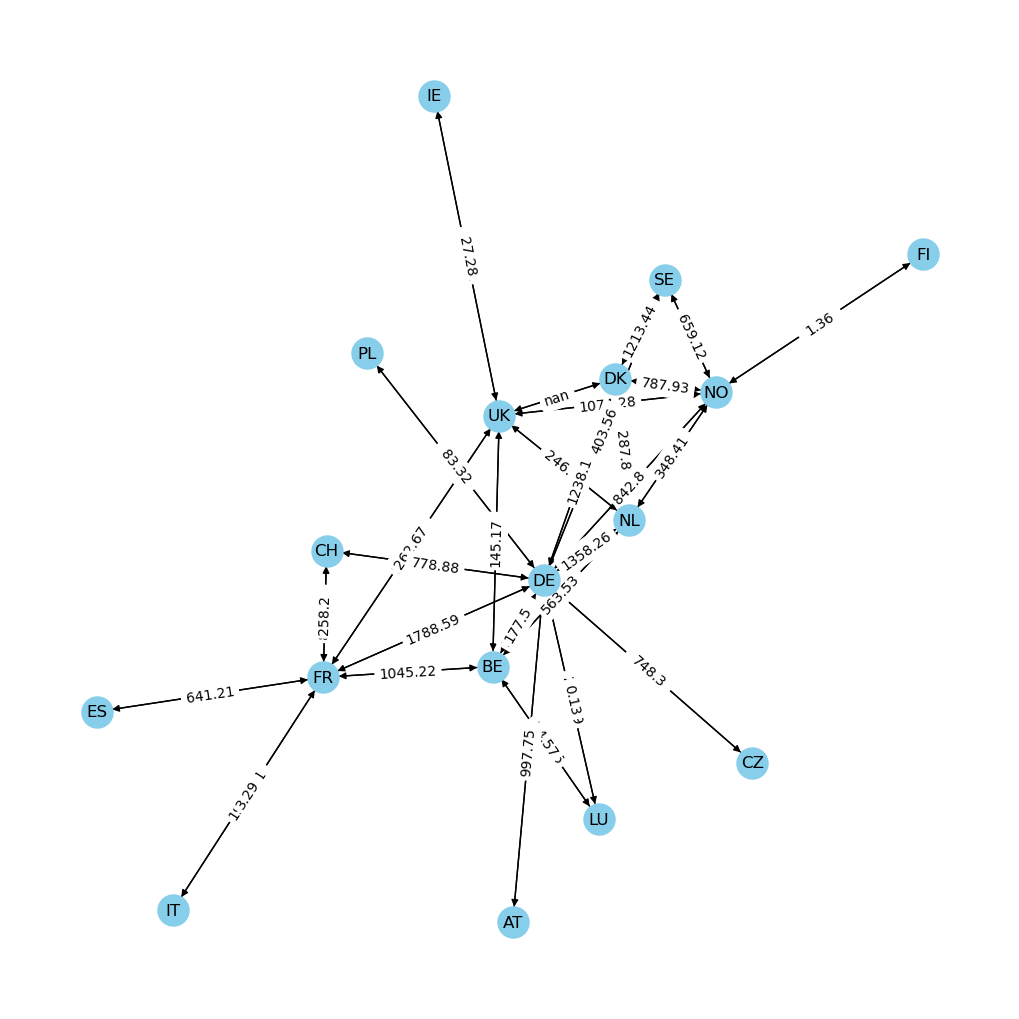

In [244]:
# Draw graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", edge_cmap=plt.cm.Blues, arrows=True)
edge_labels = nx.get_edge_attributes(G, "flow")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

In [236]:
# Print ranked betweenness centrality and closeness centrality
print("Betweenness centrality")
print(sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True))
print("Closeness centrality")
print(sorted(nx.closeness_centrality(G).items(), key=lambda x: x[1], reverse=True))

Betweenness centrality
[('DE', 0.5444444444444444), ('FR', 0.2758333333333333), ('UK', 0.17916666666666667), ('NO', 0.1494444444444444), ('BE', 0.055000000000000014), ('DK', 0.024444444444444442), ('NL', 0.021666666666666667), ('LU', 0.0), ('SE', 0.0), ('AT', 0.0), ('CH', 0.0), ('CZ', 0.0), ('PL', 0.0), ('ES', 0.0), ('IT', 0.0), ('FI', 0.0), ('IE', 0.0)]
Closeness centrality
[('DE', 0.7272727272727273), ('FR', 0.5925925925925926), ('BE', 0.5714285714285714), ('NO', 0.5714285714285714), ('NL', 0.5517241379310345), ('UK', 0.5517241379310345), ('DK', 0.5517241379310345), ('SE', 0.5), ('CH', 0.5), ('LU', 0.47058823529411764), ('AT', 0.43243243243243246), ('CZ', 0.43243243243243246), ('PL', 0.43243243243243246), ('ES', 0.38095238095238093), ('IT', 0.38095238095238093), ('FI', 0.37209302325581395), ('IE', 0.36363636363636365)]


In [237]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Node Features:
# - Actual generation by fuel type
# - Local demand
# - Local day-ahead price

# Edge Features:
# - Flow between nodes

In [ ]:
# Node labels


